In [1]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure
from equations.capm import CAPM
from sklearn.preprocessing import normalize
from datetime import timedelta
import yfinance as yf
import warnings
warnings.simplefilter(action="ignore")

In [2]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [4]:
market.connect()
index = market.retrieve("sp500")
market.disconnect()
factors = ["AMZN","NVDA","AAPL","META","GOOGL","TSLA","MSFT"]
fred.connect()
sp500 = p.column_date_processing(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
interest_rates = p.column_date_processing(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect
macro = sp500.merge(interest_rates,on="date",how="left")

In [5]:
market_caps = {}
for ticker in tqdm(index["ticker"]):
    try:
        stock_info = yf.Ticker(ticker).info
        market_caps[ticker] = stock_info['marketCap']
    except KeyError:
        market_caps[ticker] = None  # Handle missing data

# Convert to DataFrame
market_caps_df = pd.DataFrame(list(market_caps.items()), columns=['ticker', 'market_cap'])

print(market_caps_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [01:54<00:00,  4.40it/s]

    ticker    market_cap
0      MMM  7.089068e+10
1      AOS  9.922008e+09
2      ABT  1.994456e+11
3     ABBV  3.145686e+11
4      ACN  2.227835e+11
..     ...           ...
497    XYL  2.855332e+10
498    YUM  3.773891e+10
499   ZBRA  2.006823e+10
500    ZBH  2.127504e+10
501    ZTS  7.426176e+10

[502 rows x 2 columns]


In [6]:
market.connect()
factors_df = []
for ticker in tqdm(factors):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["date"] = price["date"].shift(-60)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
factors_df = pd.concat(factors_df).sort_values("date").pivot_table(index=["date"],columns="ticker",values="adjclose").reset_index()
factors_df

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 23.17it/s]


ticker,date,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
0,2011-03-21,9.795083,9.2380,15.129165,NaN,21.661630,0.344631,2.175333
1,2011-03-22,9.748090,9.1295,15.097682,NaN,21.748084,0.342109,2.006000
2,2011-03-23,9.780623,9.1070,15.051457,NaN,21.571333,0.343944,1.703267
3,2011-03-24,9.804421,9.0545,14.965003,NaN,21.525224,0.342568,1.760667
4,2011-03-25,9.798999,9.1685,15.016975,NaN,21.494484,0.342568,1.848667
...,...,...,...,...,...,...,...,...
3458,2024-12-16,227.948911,191.6000,163.403647,560.900733,434.396724,115.992004,238.250000
3459,2024-12-17,226.220814,193.8800,161.665629,563.958284,432.640255,116.251986,250.000000
3460,2024-12-18,227.119824,193.9600,162.105128,562.879148,428.308963,120.861668,254.270000
3461,2024-12-19,226.120924,192.5300,161.306039,567.855163,431.243064,123.501486,257.020000


In [7]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = factors_df.merge(price[["date","ticker","adjclose"]],on="date",how="left")
        price["year"] = price["date"].dt.year
        price["quarter"] = price["date"].dt.quarter
        price["y"] = price["adjclose"].shift(-60)
        training_data = price[(price["year"]>=2015) & (price["year"] < 2022)].dropna(subset=factors).dropna()
        sim = price[price["year"]>=2021].dropna(subset=factors)
        model = XGBRegressor()
        model.fit(training_data[factors],training_data["y"])
        sim["prediction"] = model.predict(sim[factors])
        sim = sim.merge(macro,on="date",how="left")
        sim = CAPM.apply(sim)
        prices.append(sim)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

 12%|██████████████████▉                                                                                                                                      | 62/502 [00:10<01:00,  7.28it/s]

'date'


 15%|███████████████████████▍                                                                                                                                 | 77/502 [00:13<00:58,  7.32it/s]

'date'


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 502/502 [01:31<00:00,  5.51it/s]

'date'


In [9]:
simulation = pd.concat(prices).merge(index,on="ticker",how="left").merge(market_caps_df,on="ticker",how="left")
simulation["year"] = simulation["date"].dt.year
simulation["quarter"] = simulation["date"].dt.quarter
simulation = simulation[(simulation["year"]>=2022)].dropna()
tickers = list(simulation[simulation["year"]==2022]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]
simulation["rank"] = simulation.groupby(["date","GICS Sector"])["factor"].rank(method="dense",ascending=False).astype(int)
simulation["exposure"] = [1 if x <= simulation["rank"].max() * 0.50 else -1 if x > simulation["rank"].max() * 0.50 else 1.0/6.0 for x in simulation["rank"]]
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]
simulation.sort_values("date",inplace=True)

In [99]:
benchmark = macro.copy()
benchmark["year"] = benchmark["date"].dt.year
benchmark["quarter"] = benchmark["date"].dt.quarter
benchmark = benchmark[benchmark["year"]>=2022].drop([x for x in benchmark.columns if "real" in x],axis=1).groupby(["year","quarter"]).mean().reset_index()
benchmark["sp500"] = (benchmark["sp500"] - benchmark["sp500"].iloc[0]) /benchmark["sp500"].iloc[0]
benchmark["rf"] = (benchmark["rf"] - benchmark["rf"].iloc[0]) /benchmark["rf"].iloc[0]
benchmark["sp500_prediction"] = (benchmark["sp500_prediction"] - benchmark["sp500_prediction"].iloc[0]) /benchmark["sp500_prediction"].iloc[0]
benchmark.dropna(inplace=True)

In [100]:
def rank_list(value,i):
    # Ensure i is a non-negative integer
    if value == 0:
        if i < 0:
            raise ValueError("The number of integers, i, must be non-negative.")
        
        if i % 2 == 0:
            # Even number of elements: Symmetric around 0
            return list(range(-i // 2, i // 2))
        else:
            # Odd number of elements: Includes 0
            return list(range(-i // 2, i // 2 + 1))
    if value == -1:
        return list(range(-1,-i-1,-1))
    else:
        return list(range(0,i+1,1))

In [101]:
filtered_columns = ["year","quarter","date","sell_date","GICS Sector","ticker","rank","exposure","adjclose","sell_price"]
agg_query = {"date":"first","sell_date":"last","GICS Sector":"first","exposure":"first","rank":"first","adjclose":"first","sell_price":"last"}

In [102]:
minimum_index = 100
maximum_index = 1
num_stocks_per_industry = 1
value = 1
direction = 1
stacks = rank_list(value,num_stocks_per_industry)

In [103]:
stacks = rank_list(value,num_stocks_per_industry)
max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
trades = filtered_simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).reset_index()
trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","GICS Sector"]).nth(stacks).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"] * direction 
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod() - 1
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")

In [104]:
trades.sort_values("return",ascending=False).head(10)

,index,year,quarter,ticker,date,sell_date,GICS Sector,exposure,rank,adjclose,sell_price,return
78,2012,2023,2,CCL,2023-04-03,2023-06-30,Consumer Discretionary,1,1,9.970000,18.830000,0.888666
49,272,2022,1,OXY,2022-01-03,2022-03-31,Energy,1,1,29.952114,54.839834,0.830917
170,1794,2023,1,META,2023-01-03,2023-03-31,Communication Services,1,3,124.267285,211.136831,0.699054
175,2252,2023,2,RCL,2023-04-03,2023-06-30,Consumer Discretionary,1,3,64.102680,103.502132,0.614630
36,1336,2022,4,HAL,2022-10-03,2022-12-30,Energy,1,1,25.279188,37.837062,0.496767
13,2917,2023,4,INTC,2023-10-02,2023-12-29,Information Technology,1,1,34.869329,49.575724,0.421757
225,3034,2023,4,RCL,2023-10-02,2023-12-29,Consumer Discretionary,1,4,91.489739,129.193090,0.412105
193,1098,2022,3,SMCI,2022-07-01,2022-09-30,Information Technology,1,3,3.913000,5.507000,0.407360
113,1487,2022,4,SLB,2022-10-03,2022-12-30,Energy,1,2,36.521533,51.152911,0.400623
135,4143,2024,3,MMM,2024-07-01,2024-09-26,Industrials,1,2,99.541814,138.691989,0.393304


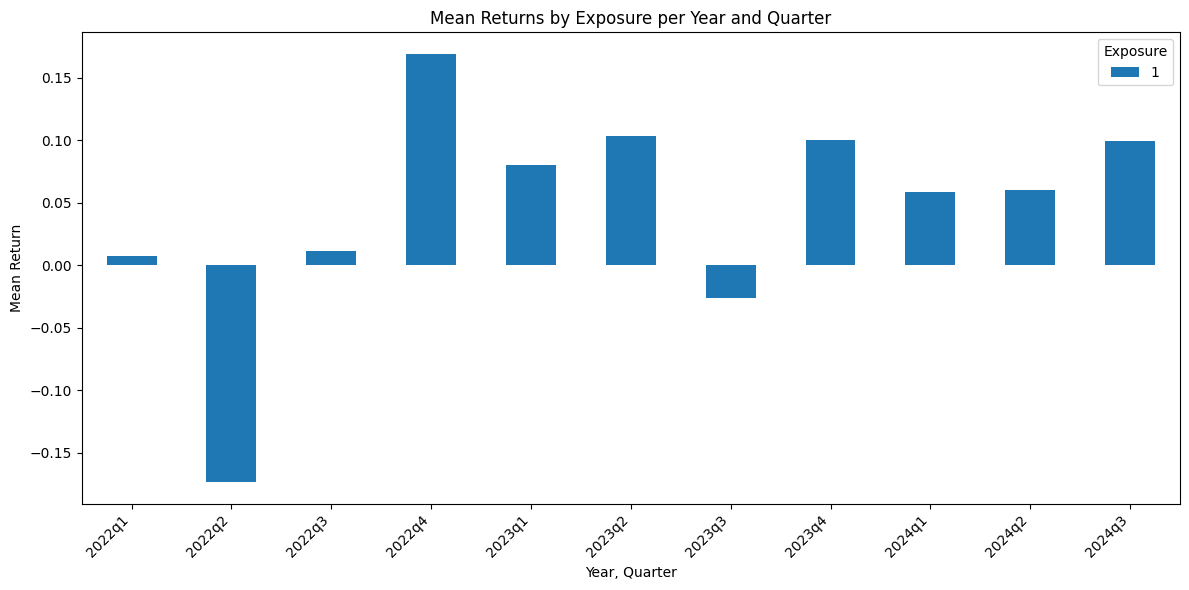

In [105]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


<Axes: title={'center': 'Mean Returns by Exposure per Year and Quarter'}, xlabel='Year-Quarter'>

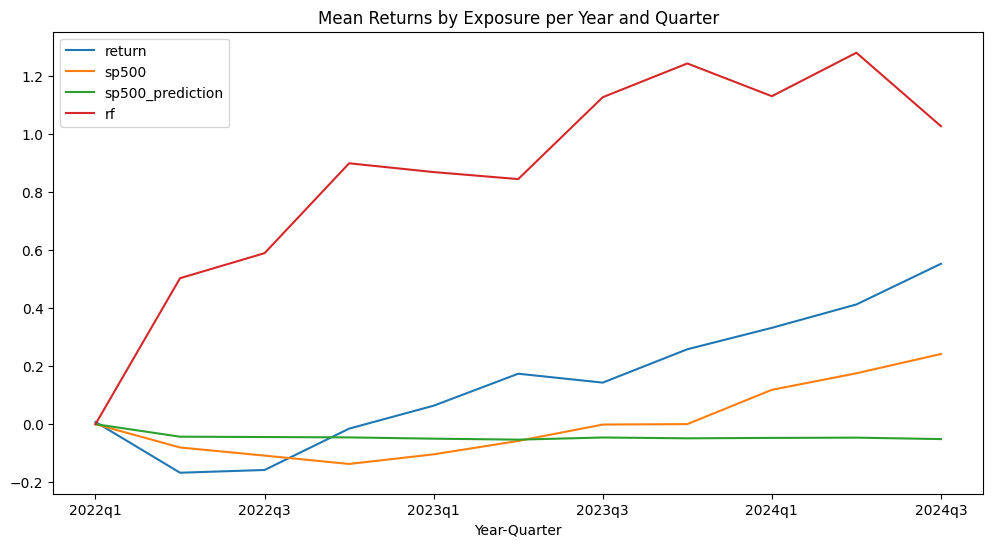

In [106]:
portfolio.drop(["date","year","quarter"],axis=1).set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

In [107]:
trades.groupby(["year","quarter","GICS Sector"]).agg({"return":"mean"}).tail(20)

return
year quarter GICS Sector                     
2024 2       Consumer Staples        0.026982
             Energy                  0.029512
             Financials             -0.033471
             Health Care             0.055046
             Industrials             0.007170
             Information Technology  0.173435
             Materials               0.083523
             Real Estate             0.059130
             Utilities               0.046218
     3       Communication Services  0.077164
             Consumer Discretionary -0.028078
             Consumer Staples        0.083034
             Energy                 -0.087469
             Financials              0.154220
             Health Care             0.040013
             Industrials             0.305487
             Information Technology  0.130423
             Materials               0.129472
             Real Estate             0.069218
             Utilities               0.217464

In [108]:
run = True
if run:
    analysises = []
    for direction in tqdm([1,-1]):
        for value in tqdm([1,0,-1]):
            for maximum_index in tqdm([1,50,100]):
                for minimum_index in [0,50,100]:
                    for num_stocks_per_industry in [1,5]:
                        try:
                            parameters = {
                                "direction":direction,
                                "val":value,
                                "maxi": maximum_index,
                                "mini": minimum_index,
                                "stacks": num_stocks_per_industry
                            }
                            stacks = rank_list(value,num_stocks_per_industry)
                            max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
                            min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
                            filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
                            trades = filtered_simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).reset_index()
                            trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","GICS Sector"]).nth(stacks).reset_index()
                            trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
                            trades["return"] = trades["return"] * trades["exposure"] * direction 
                            analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
                            portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
                            portfolio["return"] = portfolio["return"] + 1
                            portfolio["return"] = portfolio["return"].cumprod() - 1
                            portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
                            portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")
                            portfolio["sharpe"] = portfolio["return"] - portfolio["rf"] / portfolio["return"].std()
                            parameters["risk"] = portfolio["return"].std()
                            parameters["sharpe"] = portfolio["sharpe"].iloc[-1]
                            parameters["return"] = portfolio["return"].iloc[-1]
                            analysises.append(parameters)
                        except Exception as e:
                            print(str(e))
                            continue

  0%|                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]

 33%|████████████████████████████████████████████████████                                                                                                        | 1/3 [00:03<00:06,  3.28s/it]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                    | 2/3 [00:06<00:03,  3.16s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:09<00:00,  3.17s/it]

 33%|██████████████████████████████

In [109]:
a = pd.DataFrame(analysises)
a["color"] = ["blue" if x == 1 else "red" if x == -1  else "green" for x in a["val"]]
a["return_to_risk"] = a["return"] / a["risk"]
a.sort_values("return",ascending=False).head(50).dropna()

,direction,val,maxi,mini,stacks,risk,sharpe,return,color,return_to_risk
4,1,1,1,100,1,0.229541,-3.920819,0.552758,blue,2.408097
16,1,1,100,100,1,0.189005,-5.015516,0.417534,blue,2.209124
10,1,1,50,100,1,0.185157,-5.133352,0.412600,blue,2.228380
2,1,1,1,50,1,0.186091,-5.128820,0.389308,blue,2.092037
5,1,1,1,100,5,0.160720,-6.021303,0.367885,blue,2.288976
11,1,1,50,100,5,0.147458,-6.645833,0.317995,blue,2.156516
3,1,1,1,50,5,0.149461,-6.553843,0.316652,blue,2.118624
17,1,1,100,100,5,0.138481,-7.139840,0.275414,blue,1.988825
14,1,1,100,50,1,0.156352,-6.297987,0.269686,blue,1.724862
9,1,1,50,50,5,0.135005,-7.339244,0.266919,blue,1.977101


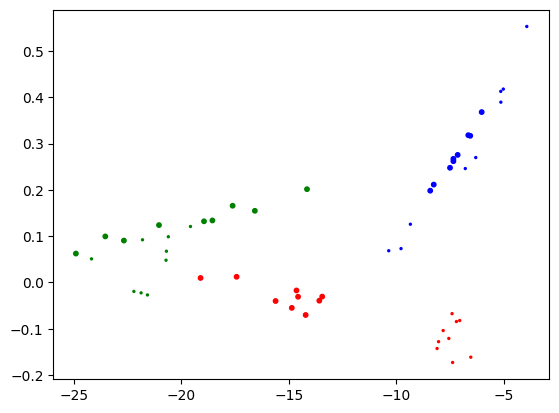

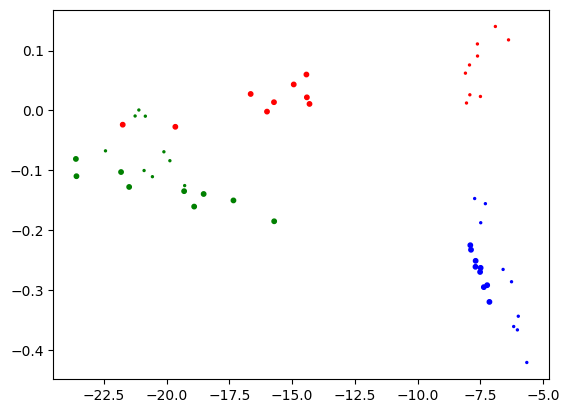

In [111]:
for direction in [1,-1]:
    d_analysis = a[a["direction"]== direction]
    plt.scatter(d_analysis["sharpe"],d_analysis["return"],c=d_analysis["color"],s=d_analysis["stacks"]*2)
    plt.show()